# Imports and load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
import lightgbm as lgb
from lightgbm import LGBMRegressor, Dataset

from hyperopt import hp, fmin, STATUS_OK, STATUS_FAIL, tpe, Trials, space_eval

pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('./data/train_trees.csv')
test_df = pd.read_csv('./data/test_trees.csv')
df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,0,2,2,4,38.693151,6,1.202674,0.699127,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,2,1,1,3,6,44.358904,7,1.114338,0.898991,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,4,0,1,1,3,51.783562,9,0.468297,0.218603,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,2,2,1,4,28.600000,4,0.402359,1.546040,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,0,1,1,2,50.868493,8,1.073354,0.187856,0.187856


In [3]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_df.shape, val_df.shape

((47781, 32), (11946, 32))

In [4]:
all_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
            'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
y_col = ['monthly_rent']
train_df = train_df[all_cols + y_col]
test_df = test_df[all_cols]
print(len(all_cols))
train_df.head()

21


,town,flat_type,flat_model,subzone,planning_area,region,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,...,age_bin,age,floor_area_sqm,shortest_dist_school,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt,sti,coe,monthly_rent
16029,choa chu kang,4 room,model a,peng siang,choa chu kang,west region,0,1,1,1,...,4,24.512329,101.0,0.225921,0.814987,1.135941,1.135941,0.602295,0.961789,3050
43628,bishan,4 room,new generation,upper thomson,bishan,central region,0,2,1,2,...,6,37.271233,97.0,0.818630,0.499857,0.158186,0.158186,0.956920,0.654969,2750
13621,choa chu kang,4 room,model a,yew tee,choa chu kang,west region,0,0,0,0,...,3,24.016438,103.0,0.321979,0.490423,0.527486,0.527486,0.677828,0.778767,2900
27171,bedok,4 room,model a,bedok north,bedok,east region,0,2,0,1,...,2,16.424658,92.0,0.451415,1.253239,0.598614,0.598614,0.571224,0.157632,2100
5234,tampines,5 room,improved,simei,tampines,east region,0,1,1,2,...,5,33.435616,128.0,0.840016,0.759841,0.488631,0.488631,0.665652,0.715263,3150


In [5]:
cat_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region', 'age_bin',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km']
train_df[cat_cols] = train_df[cat_cols].astype('category')
val_df[cat_cols] = val_df[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')

# Hyperopt setup

In [6]:
num_evals = 200
device = 'gpu'

#common hyperparameters sets for all models
n_estimators = [50, 100, 200, 300, 500, 1000]
max_depth = [2, 3, 4, 5, 7, 10, 12]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0]
subsample = [0.4, 0.6, 0.8, 0.9, 1.0]
col_subsample = [0.4, 0.6, 0.8, 0.9, 1.0] # cannot use for catboost when using GPU
# col_subsample = [1.0]

### Class object for hyperparameter optimisation

In [7]:
class HPOptimiser(object):
    def __init__(self, train_pool, val_pool, train_labels=None, val_labels=None):
        self.train_pool = train_pool
        self.val_pool = val_pool
        self.train_labels = train_labels
        self.val_labels = val_labels

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.train_pool,
                eval_set=self.val_pool,
                **params['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label(), pred))
        return {'loss': loss, 'status': STATUS_OK}

    def xgboost_reg(self, para):
        reg = xgb.train(params=para['reg_params'], dtrain=self.train_pool, evals=[(self.val_pool, 'eval')], **para['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label(), pred))
        return {'loss': loss, 'status': STATUS_OK}

    def lightgbm_reg(self, para):
        reg = lgb.train(para['reg_params'], self.train_pool, **para['fit_params'])
        pred = reg.predict(self.val_pool.get_data().loc[:,:])
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label().copy(), pred))
        return {'loss': loss, 'status': STATUS_OK}

# Catboost

In [8]:
# Choose which subset of columns to use with the categorical columns first then set n_cat_cols to the number of categorical columns

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe', 'hdb_index']
# n_cat_cols = 13

x_col = ['flat_type', 'subzone', 'num_top_sch_2km', 'num_top_sch_1km', 'num_good_sch_1km', 'num_good_sch_2km', 'flat_model',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
n_cat_cols = 7

### Test run before optimisation of hyperparameters

In [9]:

train_pool = Pool(train_df[x_col], train_df[y_col], cat_features=np.arange(n_cat_cols))
val_pool = Pool(val_df[x_col], val_df[y_col], cat_features=np.arange(n_cat_cols))
test_pool = Pool(test_df[x_col], cat_features=np.arange(n_cat_cols))

cat_model = CatBoostRegressor(iterations=500,
                          depth=3,
                          learning_rate=0.05,
                          bootstrap_type='Bernoulli',
                          subsample=0.6,
                        #   colsample_bylevel=0.8,
                        #   l2_leaf_reg=5,
                          loss_function='RMSE',
                          task_type='GPU')
# train the model
cat_model.fit(train_pool, plot=True, eval_set=val_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 701.0830089	test: 701.8483778	best: 701.8483778 (0)	total: 22.4ms	remaining: 11.2s
1:	learn: 688.5776616	test: 689.5651468	best: 689.5651468 (1)	total: 41.2ms	remaining: 10.3s
2:	learn: 676.9193620	test: 678.0207514	best: 678.0207514 (2)	total: 58.2ms	remaining: 9.65s
3:	learn: 666.3989075	test: 667.5860234	best: 667.5860234 (3)	total: 77.7ms	remaining: 9.64s
4:	learn: 656.5469310	test: 657.8540928	best: 657.8540928 (4)	total: 94.4ms	remaining: 9.34s
5:	learn: 647.6413213	test: 649.0020837	best: 649.0020837 (5)	total: 111ms	remaining: 9.16s
6:	learn: 639.4312535	test: 641.0065081	best: 641.0065081 (6)	total: 128ms	remaining: 9.02s
7:	learn: 631.7650905	test: 633.4471497	best: 633.4471497 (7)	total: 144ms	remaining: 8.88s
8:	learn: 624.7885848	test: 626.5896886	best: 626.5896886 (8)	total: 163ms	remaining: 8.91s
9:	learn: 618.3543009	test: 620.3539805	best: 620.3539805 (9)	total: 180ms	remaining: 8.83s
10:	learn: 612.4007684	test: 614.6012241	best: 614.6012241 (10)	total: 198m

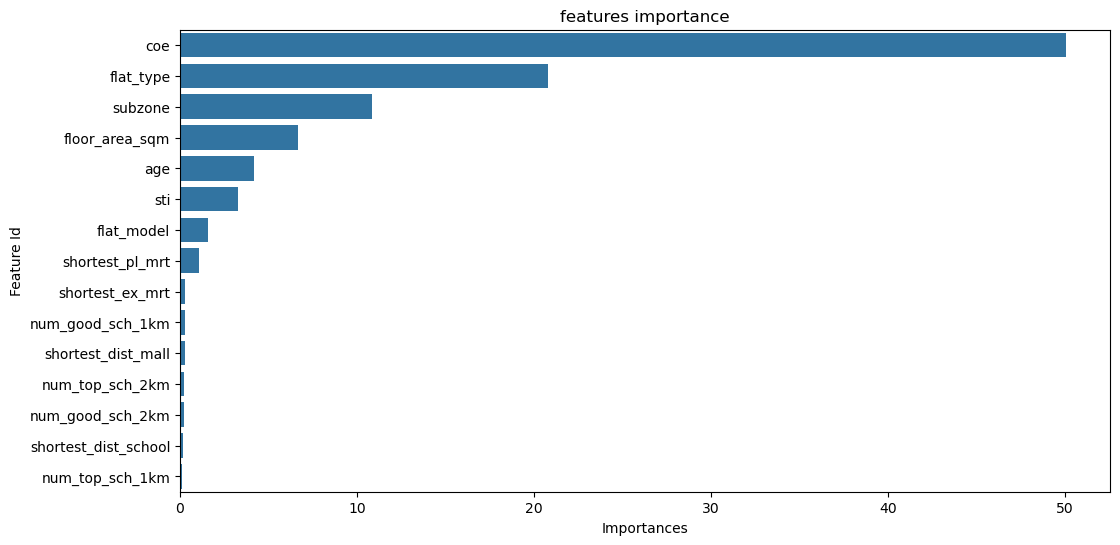

In [10]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

### Hyperparameter optimisation

In [11]:
# Catboost hyperparameters to search
catboost_hyperparams = { 'n_estimators': hp.choice('n_estimators', n_estimators),
                         'max_depth': hp.choice('max_depth', max_depth),
                         'learning_rate': hp.choice('learning_rate', learning_rate),
                         'subsample': hp.choice('subsample', subsample),
                        #  'colsample_bylevel': hp.choice('colsample_bylevel', col_subsample),
                         'bootstrap_type': hp.choice('bootstrap_type', ['Poisson', 'Bernoulli', 'MVS']),
                         'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0., 10),
                         'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
                         'loss_function': 'RMSE',
                         'eval_metric': 'RMSE',
                         'task_type': device.upper()}

catboost_fit_params = {'early_stopping_rounds': 10, 'verbose': False}

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catboost_fit_params
catboost_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [12]:
# hyperparamter optimisation
optimiser = HPOptimiser(train_pool, val_pool)
catboost_opt = optimiser.process(fn_name='catboost_reg', space=catboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

100%|██████████| 200/200 [16:40<00:00,  5.00s/trial, best loss: 486.33363916968744] 


In [13]:
# get best params
catboost_reg_params = space_eval(catboost_params['reg_params'], catboost_opt[0])
catboost_fit_params = space_eval(catboost_params['fit_params'], catboost_opt[0])
print(catboost_reg_params)
print(catboost_fit_params)

{'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'eval_metric': 'RMSE', 'l2_leaf_reg': 2.6452595700346704, 'learning_rate': 0.2, 'loss_function': 'RMSE', 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8, 'task_type': 'GPU'}
{'early_stopping_rounds': 10, 'verbose': False}


In [14]:
# get the best model
cat_model = CatBoostRegressor(**catboost_reg_params)
cat_model.fit(train_pool, plot=True, **catboost_fit_params)
preds = cat_model.predict(val_pool)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE on validation set is 486.6724866819811


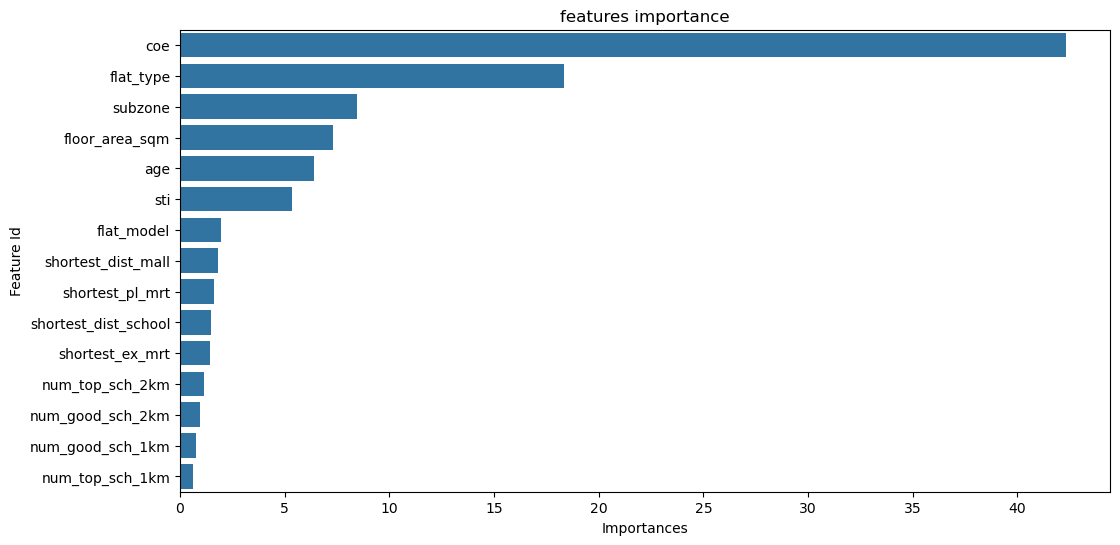

In [15]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

In [16]:
# predict on test set
preds = cat_model.predict(test_pool)
preds

array([2358.76280824, 2261.59857459, 2806.89359756, ..., 2406.74507962,
       3322.49509815, 2723.67088909])

In [17]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_catboost.csv')

# XGBoost

In [18]:
# Choose which subset of columns to use

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe', 'hdb_index']

x_col = ['flat_type', 'subzone', 'num_top_sch_2km', 'num_top_sch_1km', 'num_good_sch_1km', 'num_good_sch_2km', 'flat_model',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']

### Test run before optimisation of hyperparameters

In [19]:
dtrain = DMatrix(data=train_df[x_col], label=train_df[y_col], enable_categorical=True)
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'device': 'gpu'}
xgb_cv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10, verbose_eval=10)
xgb_cv

[0]	train-rmse:613.57204+1.45107	test-rmse:617.58001+7.85806
[10]	train-rmse:460.70930+0.90423	test-rmse:492.78485+5.58737
[20]	train-rmse:445.64938+0.96070	test-rmse:493.06666+5.42917
[21]	train-rmse:444.60532+1.05289	test-rmse:493.21345+5.44091


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,613.572038,1.451071,617.580015,7.858057
1,554.400274,1.201367,562.019215,7.454901
2,520.075065,1.181127,530.626988,7.229919
3,500.278013,1.254622,513.819913,6.645800
4,487.963076,1.185741,504.421146,5.995545
5,479.867747,1.176346,499.218930,5.769576
6,474.350790,1.078179,496.054045,5.812415
7,469.424786,1.073967,494.720148,5.774050
8,465.927276,1.061193,493.655173,5.784098
9,462.988309,0.928098,493.183110,5.728261


In [20]:
val_df[cat_cols] = val_df[cat_cols].astype('category')
deval = DMatrix(data=val_df[x_col], label=val_df[y_col], enable_categorical=True)
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100, early_stopping_rounds=10, evals=[(dtrain, 'train'), (deval, 'eval')], verbose_eval=10)

[0]	train-rmse:613.98935	eval-rmse:630.07584
[10]	train-rmse:464.56392	eval-rmse:543.83127
[16]	train-rmse:455.79676	eval-rmse:547.94369


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

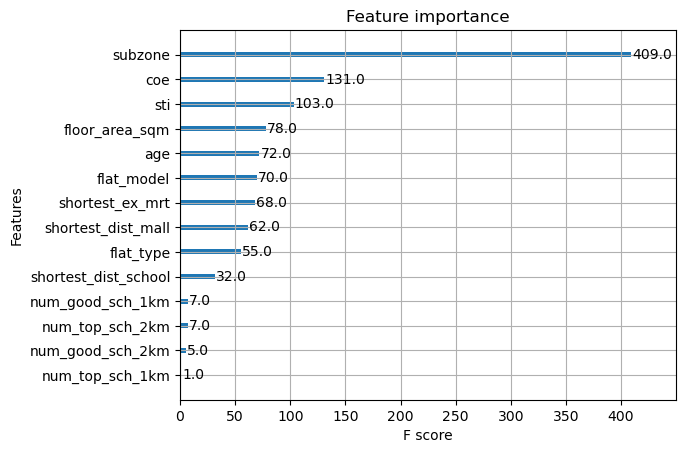

In [21]:
xgb.plot_importance(xgb_model, max_num_features=20)

### Hyperparamter optimisation

In [22]:
# xgboost hyperparameters to search
xgboost_hyperparams = { 'max_depth': hp.choice('max_depth', max_depth),
                        'learning_rate': hp.choice('learning_rate', learning_rate),
                        'subsample': hp.choice('subsample', subsample),
                        'colsample_bytree': hp.choice('colsample_bytree', subsample),
                        # 'gamma': hp.uniform ('gamma', 0, 10),
                        # 'reg_alpha': hp.quniform('reg_alpha', 20, 100, 1),
                        # 'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                        'booster': 'gbtree',
                        'objective': 'reg:squarederror',
                        'eval_metric': 'rmse',
                        'device': device}

xgboost_fit_params = {'early_stopping_rounds': 10,
                      'num_boost_round': hp.choice('num_boost_round', n_estimators),
                      'verbose_eval': False}

xgboost_params = dict()
xgboost_params['reg_params'] = xgboost_hyperparams
xgboost_params['fit_params'] = xgboost_fit_params
xgboost_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [23]:
# hyperparamter optimisation
optimiser = HPOptimiser(dtrain, deval)
xgboost_opt = optimiser.process(fn_name='xgboost_reg', space=xgboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

100%|██████████| 200/200 [03:28<00:00,  1.04s/trial, best loss: 526.82373046875] 


In [24]:
# get best params
xgboost_reg_params = space_eval(xgboost_params['reg_params'], xgboost_opt[0])
xgboost_fit_params = space_eval(xgboost_params['fit_params'], xgboost_opt[0])
print(xgboost_reg_params)
print(xgboost_fit_params)

{'booster': 'gbtree', 'colsample_bytree': 0.6, 'device': 'gpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 7, 'objective': 'reg:squarederror', 'subsample': 1.0}
{'early_stopping_rounds': 10, 'num_boost_round': 300, 'verbose_eval': False}


In [25]:
# use best params to train XGBoost
xgb_model = xgb.train(params=xgboost_reg_params, dtrain=dtrain,
                      evals=[(deval, 'eval')],
                      num_boost_round=xgboost_fit_params['num_boost_round'],
                      early_stopping_rounds=xgboost_fit_params['early_stopping_rounds'],
                      verbose_eval=10)
preds = xgb_model.predict(deval)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

[0]	eval-rmse:699.55896


[10]	eval-rmse:609.25293
[20]	eval-rmse:560.01076
[30]	eval-rmse:539.07996
[40]	eval-rmse:531.78592
[50]	eval-rmse:527.79088
[60]	eval-rmse:526.65723
[70]	eval-rmse:526.99811
[73]	eval-rmse:526.96078
RMSE on validation set is 526.8237222566964


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

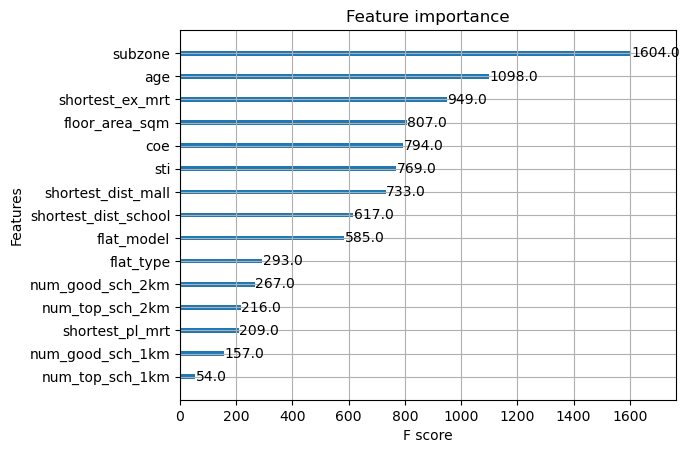

In [26]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [27]:
# predict on test set
dtest = DMatrix(data=test_df[x_col], enable_categorical=True)
preds = xgb_model.predict(dtest)
preds

array([3573.4753, 2948.2395, 3529.6104, ..., 3168.822 , 3149.838 ,
       3735.4863], dtype=float32)

In [28]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_xgboost.csv')

# LightGBM

In [29]:
# Choose which subset of columns to use

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe', 'hdb_index']

x_col = ['flat_type', 'subzone', 'num_top_sch_2km', 'num_top_sch_1km', 'num_good_sch_1km', 'num_good_sch_2km', 'flat_model',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']

In [30]:
lgb_train = Dataset(train_df[x_col], train_df[y_col], params={'verbose': -1}, free_raw_data=False).construct()
lgb_eval = Dataset(val_df[x_col], val_df[y_col], params={'verbose': -1}, free_raw_data=False).construct()

In [31]:
# lightgbm hyperparameters to search
lightgbm_hyperparams = {'max_depth': hp.choice('max_depth', max_depth),
                        'learning_rate': hp.choice('learning_rate', learning_rate),
                        'subsample': hp.choice('subsample', subsample),
                        'colsample_bytree': hp.choice('colsample_bytree', col_subsample),
                        'max_bin': hp.choice('max_bin', [32, 64, 128, 256]),
                        'num_leaves': hp.choice('num_leaves', [2, 4, 8, 16, 32, 64, 128]),
                        'min_data_in_leaf': hp.choice('min_data_in_leaf', [2, 4, 8, 16, 32, 64, 128]),
                        'gamma': hp.uniform ('gamma', 0, 10),
                        'reg_alpha': hp.quniform('reg_alpha', 20, 100, 1),
                        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                        'objective': 'regression',
                        'metric': 'rmse',
                        'device': device,
                        'verbose': -1}

lightgbm_fit_params = {'num_boost_round': hp.choice('num_boost_round', n_estimators)}#, 'verbose_eval': False}

lightgbm_params = dict()
lightgbm_params['reg_params'] = lightgbm_hyperparams
lightgbm_params['fit_params'] = lightgbm_fit_params
lightgbm_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [32]:
# hyperparamter optimisation
optimiser = HPOptimiser(lgb_train, lgb_eval)
lightgbm_opt = optimiser.process(fn_name='lightgbm_reg', space=lightgbm_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 200/200 [04:53<00:00,  1.47s/trial, best loss: 485.832261492776] 


In [33]:
# get best params
lgb_reg_params = space_eval(lightgbm_params['reg_params'], lightgbm_opt[0])
lgb_fit_params = space_eval(lightgbm_params['fit_params'], lightgbm_opt[0])
print(lgb_reg_params)
print(lgb_fit_params)

{'colsample_bytree': 0.4, 'device': 'gpu', 'gamma': 5.191855287276575, 'learning_rate': 0.05, 'max_bin': 64, 'max_depth': 12, 'metric': 'rmse', 'min_data_in_leaf': 128, 'num_leaves': 16, 'objective': 'regression', 'reg_alpha': 71.0, 'reg_lambda': 0.9560155801617218, 'subsample': 0.9, 'verbose': -1}
{'num_boost_round': 500}


In [34]:
# get the best model
lgb_model = lgb.train(lgb_reg_params, lgb_train, **lgb_fit_params)
preds = lgb_model.predict(val_df.loc[:,x_col])
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

RMSE on validation set is 485.83260559104417


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

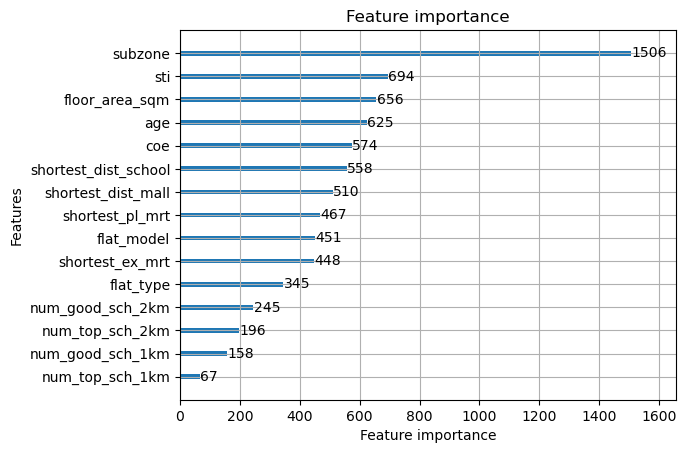

In [35]:
lgb.plot_importance(lgb_model, max_num_features=20)

In [36]:
# predict on test set
preds = lgb_model.predict(test_df.loc[:,x_col])
preds

array([2524.74621312, 2307.45789123, 2979.49740428, ..., 2493.23275347,
       3302.08688417, 2846.10756708])

In [37]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_lightgbm.csv')